In [31]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
%matplotlib inline

In [2]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [3]:
X = tf.placeholder(tf.float32, shape=[None, 784])

In [4]:
D_W1 = tf.Variable(xavier_init([784, 128]))
D_b1 = tf.Variable(tf.zeros(shape=[128]))

D_W2 = tf.Variable(xavier_init([128, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

In [5]:
Z = tf.placeholder(tf.float32, shape=[None, 16])
c = tf.placeholder(tf.float32, shape=[None, 10])

In [6]:
G_W1 = tf.Variable(xavier_init([26, 256]))
G_b1 = tf.Variable(tf.zeros(shape=[256]))

G_W2 = tf.Variable(xavier_init([256, 784]))
G_b2 = tf.Variable(tf.zeros(shape=[784]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

In [7]:
Q_W1 = tf.Variable(xavier_init([784, 128]))
Q_b1 = tf.Variable(tf.zeros(shape=[128]))

Q_W2 = tf.Variable(xavier_init([128, 10]))
Q_b2 = tf.Variable(tf.zeros(shape=[10]))

theta_Q = [Q_W1, Q_W2, Q_b1, Q_b2]

In [8]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

In [9]:
def sample_c(m):
    return np.random.multinomial(1, 10*[0.1], size=m)

In [10]:
sample_c(10)

array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

In [17]:
def generator(z, c):
    inputs = tf.concat([z, c], axis=1)
    G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob


In [12]:
def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob

In [13]:
def Q(x):
    Q_h1 = tf.nn.relu(tf.matmul(x, Q_W1) + Q_b1)
    Q_prob = tf.nn.softmax(tf.matmul(Q_h1, Q_W2) + Q_b2)

    return Q_prob

In [14]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [18]:
G_sample = generator(Z, c)
D_real = discriminator(X)
D_fake = discriminator(G_sample)
Q_c_given_x = Q(G_sample)

D_loss = -tf.reduce_mean(tf.log(D_real + 1e-8) + tf.log(1 - D_fake + 1e-8))
G_loss = -tf.reduce_mean(tf.log(D_fake + 1e-8))

cross_ent = tf.reduce_mean(-tf.reduce_sum(tf.log(Q_c_given_x + 1e-8) * c, 1))
ent = tf.reduce_mean(-tf.reduce_sum(tf.log(c + 1e-8) * c, 1))
Q_loss = cross_ent + ent

D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)
Q_solver = tf.train.AdamOptimizer().minimize(Q_loss, var_list=theta_G + theta_Q)


In [22]:
mb_size = 32
Z_dim = 16

mnist = input_data.read_data_sets('.', one_hot=True)

sess = tf.Session()
sess.run(tf.initialize_all_variables())

if not os.path.exists('out/'):
    os.makedirs('out/')

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz
Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [27]:
i = 0

for it in range(50000):
    if it % 1000 == 0:
        Z_noise = sample_Z(16, Z_dim)

        idx = np.random.randint(0, 10)
        c_noise = np.zeros([16, 10])
        c_noise[range(16), idx] = 1

        samples = sess.run(G_sample,
                           feed_dict={Z: Z_noise, c: c_noise})

        fig = plot(samples)
        plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)

    X_mb, _ = mnist.train.next_batch(mb_size)
    Z_noise = sample_Z(mb_size, Z_dim)
    c_noise = sample_c(mb_size)

    _, D_loss_curr = sess.run([D_solver, D_loss],
                              feed_dict={X: X_mb, Z: Z_noise, c: c_noise})

    _, G_loss_curr = sess.run([G_solver, G_loss],
                              feed_dict={Z: Z_noise, c: c_noise})

    sess.run([Q_solver], feed_dict={Z: Z_noise, c: c_noise})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))

Iter: 0
D loss: 0.9443
G_loss: 1.55
Iter: 1000
D loss: 0.9488
G_loss: 1.349
Iter: 2000
D loss: 1.082
G_loss: 1.263
Iter: 3000
D loss: 1.049
G_loss: 2.146
Iter: 4000
D loss: 0.999
G_loss: 1.278
Iter: 5000
D loss: 0.8388
G_loss: 1.316
Iter: 6000
D loss: 1.225
G_loss: 1.208
Iter: 7000
D loss: 0.8427
G_loss: 1.54
Iter: 8000
D loss: 0.9957
G_loss: 1.364
Iter: 9000
D loss: 1.048
G_loss: 1.278
Iter: 10000
D loss: 1.152
G_loss: 1.352
Iter: 11000
D loss: 1.057
G_loss: 1.262
Iter: 12000
D loss: 1.23
G_loss: 1.148
Iter: 13000
D loss: 1.082
G_loss: 1.481
Iter: 14000
D loss: 1.025
G_loss: 1.269
Iter: 15000
D loss: 1.069
G_loss: 1.528
Iter: 16000
D loss: 0.9988
G_loss: 1.534
Iter: 17000
D loss: 1.179
G_loss: 1.364
Iter: 18000
D loss: 0.9303
G_loss: 1.678
Iter: 19000
D loss: 1.088
G_loss: 1.23
Iter: 20000
D loss: 0.8347
G_loss: 1.448
Iter: 21000
D loss: 0.9531
G_loss: 1.275
Iter: 22000
D loss: 1.17
G_loss: 1.51
Iter: 23000
D loss: 1.014
G_loss: 1.099
Iter: 24000
D loss: 1.143
G_loss: 1.127
Iter: 2500

In [28]:
!ls ./out

000.png  006.png  012.png  018.png  024.png  030.png  036.png  042.png	048.png
001.png  007.png  013.png  019.png  025.png  031.png  037.png  043.png	049.png
002.png  008.png  014.png  020.png  026.png  032.png  038.png  044.png
003.png  009.png  015.png  021.png  027.png  033.png  039.png  045.png
004.png  010.png  016.png  022.png  028.png  034.png  040.png  046.png
005.png  011.png  017.png  023.png  029.png  035.png  041.png  047.png


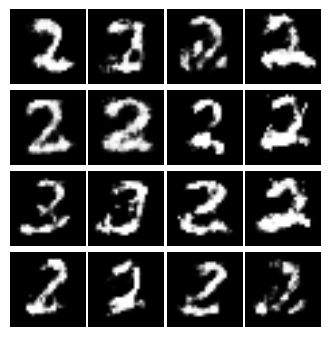

In [127]:
from IPython.display import Image
Image('./out/049.png')

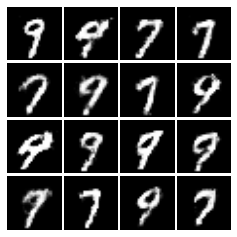

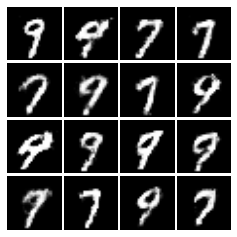

In [33]:
Z_noise = sample_Z(16, Z_dim)

idx = np.random.randint(0, 10)
c_noise = np.zeros([16, 10])
c_noise[range(16), idx] = 1

samples = sess.run(G_sample,feed_dict={Z: Z_noise, c: c_noise})

plot(samples)

In [53]:
def plot_mnist(n):
    Z_noise = sample_Z(1, Z_dim)
    c_noise = np.zeros([1, 10])
    c_noise[:, n] = 1
    samples = sess.run(G_sample,feed_dict={Z: Z_noise, c: c_noise})
    plt.imshow(samples.reshape(28, 28), cmap='Greys_r')

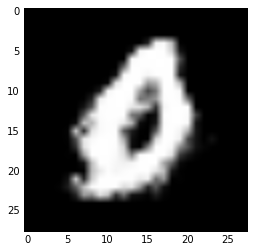

In [55]:
plot_mnist(0)

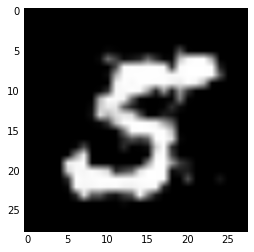

In [65]:
plot_mnist(1)

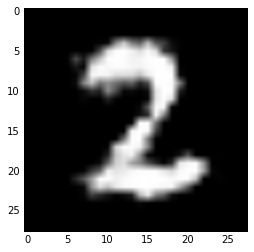

In [72]:
plot_mnist(2)

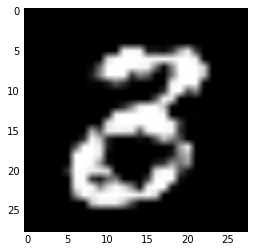

In [93]:
plot_mnist(3)

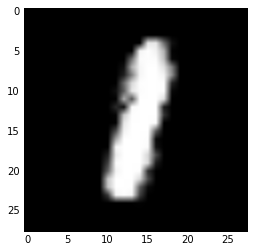

In [96]:
plot_mnist(4)

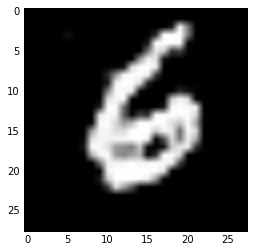

In [98]:
plot_mnist(5)

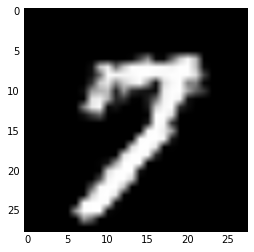

In [99]:
plot_mnist(6)

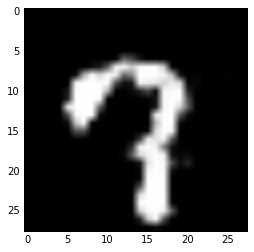

In [110]:
plot_mnist(7)

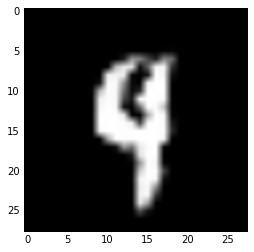

In [117]:
plot_mnist(8)

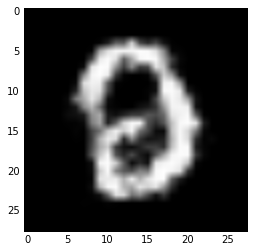

In [126]:
plot_mnist(9)